In [91]:
import cv2
import os
import numpy as np

directory_path = 'MCI/video_sequence'
frame_list = []

width = height = 128

for filename in os.listdir(directory_path):
    if filename.endswith(".avi"):
        video_path = os.path.join(directory_path, filename)
        cap = cv2.VideoCapture(video_path)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Resize the frame
            resized_frame = cv2.resize(gray_frame, (width, height))

            # Add the frame to the list
            frame_list.append(resized_frame)

        cap.release()

cv2.destroyAllWindows()

# Checking the shape of the first frame in the list
print(len(frame_list))
print(frame_list[0].shape)  # Should output: (32, 32)

25200
(128, 128)


In [92]:
frame_list

[array([[73, 74, 71, ..., 41,  6,  4],
        [77, 70, 70, ..., 37,  7,  3],
        [83, 76, 81, ..., 31, 10, 10],
        ...,
        [79, 80, 76, ..., 37,  6,  3],
        [86, 75, 92, ..., 56,  5,  5],
        [80, 81, 66, ..., 51,  6,  3]], dtype=uint8),
 array([[ 71, 100,  83, ...,  48,   6,   6],
        [ 68,  77,  82, ...,  39,   5,   4],
        [ 77,  94,  67, ...,  37,   9,   9],
        ...,
        [ 74,  70,  66, ...,  48,   6,   4],
        [ 76,  83,  66, ...,  37,   4,   5],
        [ 73,  76,  72, ...,  47,   6,   4]], dtype=uint8),
 array([[74, 67, 83, ..., 46,  6,  5],
        [71, 73, 73, ..., 34,  5,  4],
        [75, 74, 83, ..., 37, 10, 10],
        ...,
        [73, 77, 76, ..., 52,  7,  4],
        [76, 67, 80, ..., 43,  5,  5],
        [91, 84, 78, ..., 51,  5,  4]], dtype=uint8),
 array([[81, 69, 71, ..., 61,  7,  5],
        [78, 64, 72, ..., 31,  4,  5],
        [82, 86, 92, ..., 31,  9,  9],
        ...,
        [82, 82, 80, ..., 45,  5,  3],
        [

In [93]:
# Convert list to NumPy array and add an extra dimension
X_train = np.array(frame_list, dtype=np.float32)[..., np.newaxis]

# Normalize the data to the range [0, 1]
X_train = X_train / 255.0

print(X_train.shape)  # Should output: (num_frames, 32, 32, 1)


(25200, 128, 128, 1)


In [94]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, BatchNormalization, Reshape, Flatten, Dense
from tensorflow.keras.models import Model
import numpy as np

def build_autoencoder(input_shape):
    # Encoder
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=2, padding='same')(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    # Flatten and bottleneck
    volume_size = x.shape
    x = Flatten()(x)
    latent = Dense(100)(x)  # Latent vector

    # Build the encoder model
    encoder = Model(input_layer, latent, name="encoder")

    # Decoder
    decoder_input = Input(shape=(100,))
    x = Dense(np.prod(volume_size[1:]))(decoder_input)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    output_layer = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Build the decoder model
    decoder = Model(decoder_input, output_layer, name="decoder")

    # Autoencoder
    autoencoder = Model(input_layer, decoder(encoder(input_layer)), name="autoencoder")
    return autoencoder, encoder, decoder


In [96]:
autoencoder, encoder, decoder = build_autoencoder(input_shape=(128, 128, 1))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True)

Epoch 1/50
99/99 [==============================] - 359s 4s/step - loss: 0.6240
Epoch 2/50
99/99 [==============================] - 353s 4s/step - loss: 0.6012
Epoch 3/50
99/99 [==============================] - 293s 3s/step - loss: 0.6003
Epoch 4/50
99/99 [==============================] - 497s 5s/step - loss: 0.5998
Epoch 5/50
99/99 [==============================] - 372s 4s/step - loss: 0.5995
Epoch 6/50
99/99 [==============================] - 340s 3s/step - loss: 0.5992
Epoch 7/50
99/99 [==============================] - 323s 3s/step - loss: 0.5989
Epoch 8/50
99/99 [==============================] - 335s 3s/step - loss: 0.5988
Epoch 9/50
99/99 [==============================] - 369s 4s/step - loss: 0.5986
Epoch 10/50
99/99 [==============================] - 395s 4s/step - loss: 0.5985
Epoch 11/50
99/99 [==============================] - 406s 4s/step - loss: 0.5984
Epoch 12/50
99/99 [==============================] - 357s 4s/step - loss: 0.5983
Epoch 13/50
99/99 [==================

In [122]:
# autoencoder.save('endecoder.h5')
# encoder.save('encoder.h5')
# decoder.save('decoder.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
latent_vector = encoder.predict(X_train)


In [171]:

# Random Sampling from Latent Vectors
# num_samples = 10  # Number of samples to select
# selected_indices = np.random.choice(len(latent_vector), num_samples, replace=False)
# new_vector = np.mean(latent_vector[selected_indices], axis=0)

# Interpolating two of the Latent Vector
alpha = 0.5  # Interpolation factor
idx1, idx2 = np.random.choice(len(latent_vector), 2, replace=False)
new_vector = alpha * latent_vector[idx1] + (1 - alpha) * latent_vector[idx2]

# Adding Noise to Average Vector
# noise_factor = 0.05  # Adjust as needed
# average_vector = np.mean(latent_vector, axis=0)
# noise = np.random.normal(0, noise_factor, average_vector.shape)
# new_vector = average_vector + noise

reconstructed_image = decoder.predict(np.array([new_vector]))
reconstructed_image.shape

1/1 [==============================] - 0s 18ms/step


(1, 128, 128, 1)

In [173]:
import numpy as np

def mse(imageA, imageB):
    # Calculate the mean squared error between the two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def get_max_pixel_value(image):
    if image.dtype == np.uint8:  # 8-bit image
        return 255
    elif image.dtype == np.uint16:  # 16-bit image
        return 65535
    elif image.dtype == np.float32 or image.dtype == np.float64:
        # Assuming normalized float (0.0 to 1.0)
        return 1.0
    else:
        raise ValueError("Unsupported image data type")

def psnr(original, reconstructed):
    mse_value = mse(original, reconstructed)
    if mse_value == 0:
        return float('inf')  # Infinite PSNR means no difference between images

    max_pixel = get_max_pixel_value(original)
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse_value))
    return psnr_value

# Example usage
original_image = frame_list[0]
reconstructed_image = reconstructed_image
psnr_value = psnr(original_image, reconstructed_image)
print(f"PSNR: {psnr_value} dB")

PSNR: -8.561634275092379 dB


In [180]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(imageA, imageB):
    # Compute the mean structural similarity index between two images
    s = ssim(imageA, imageB, data_range=imageA.max() - imageA.min())
    return s

# Example usage
original_image = frame_list[0]  # Your original image
reconstructed_image = reconstructed_image
ssim_value = calculate_ssim(original_image, reconstructed_image[0, :, :, 0])
print(f"SSIM: {ssim_value}")


SSIM: 0.0031044255491307115


In [216]:
alpha = 0.05  # Interpolation factor
num_frames = 350  # Number of frames to generate

# first frame
idx1, idx2 = np.random.choice(len(latent_vector), 2, replace=False)
new_vector = alpha * latent_vector[idx1] + (1 - alpha) * latent_vector[idx2]

reconstructed_image_frames = []

for _ in range(num_frames):
    frame = decoder.predict(np.array([new_vector]))[0]
    reconstructed_image_frames.append(frame)

    idx = np.random.choice(len(latent_vector), 1, replace=False)
    new_vector = alpha * latent_vector[idx[0]] + (1 - alpha) * new_vector

1/1 [==============================] - 0s 15ms/step


In [218]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def show_frame(frame_index):
    frame = reconstructed_image_frames[frame_index]

    # Rescale if the frames are normalized
    if frame.max() <= 1.0:
        frame = frame * 255.0

    # Use 'gray' color map if the images are grayscale
    plt.imshow(frame.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.show()

# Create a slider to browse through the frames
frame_slider = widgets.IntSlider(value=0, min=0, max=len(reconstructed_image_frames)-1, step=1, description='Frame:')

# Display the widget
widgets.interactive(show_frame, frame_index=frame_slider)


interactive(children=(IntSlider(value=0, description='Frame:', max=349), Output()), _dom_classes=('widget-inte…

In [214]:
import cv2
from time import sleep

sleep(5)

for frame in reconstructed_image_frames:
    # Convert frame to BGR if it's in grayscale or another format
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    # Display the frame
    cv2.imshow('Frame', frame)

    # Wait for 25 ms and break the loop with a keyboard interrupt
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Close the window
cv2.destroyAllWindows()


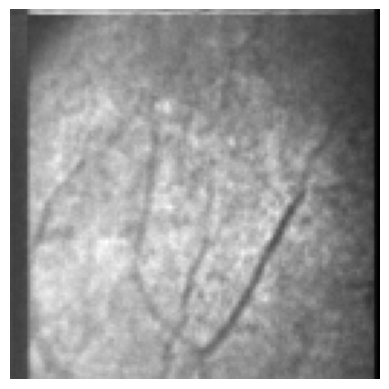

In [172]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def show_frame():
    frame = reconstructed_image[0]

    # Rescale if the frames are normalized
    if frame.max() <= 1.0:
        frame = frame * 255.0

    # Use 'gray' color map if the images are grayscale
    plt.imshow(frame.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.show()

show_frame()